## 1. Thread Count Analysis

Threads: 1, Time: 8.529000 seconds
Threads: 2, Time: 4.943000 seconds
Threads: 4, Time: 3.131000 seconds
Threads: 8, Time: 2.244000 seconds
Threads: 16, Time: 1.985000 seconds


,Threads,Time,Speedup,Efficiency
0,1,8.529,1.000000,1.000000
1,2,4.943,1.725470,0.862735
2,4,3.131,2.724050,0.681012
3,8,2.244,3.800802,0.475100
4,16,1.985,4.296725,0.268545


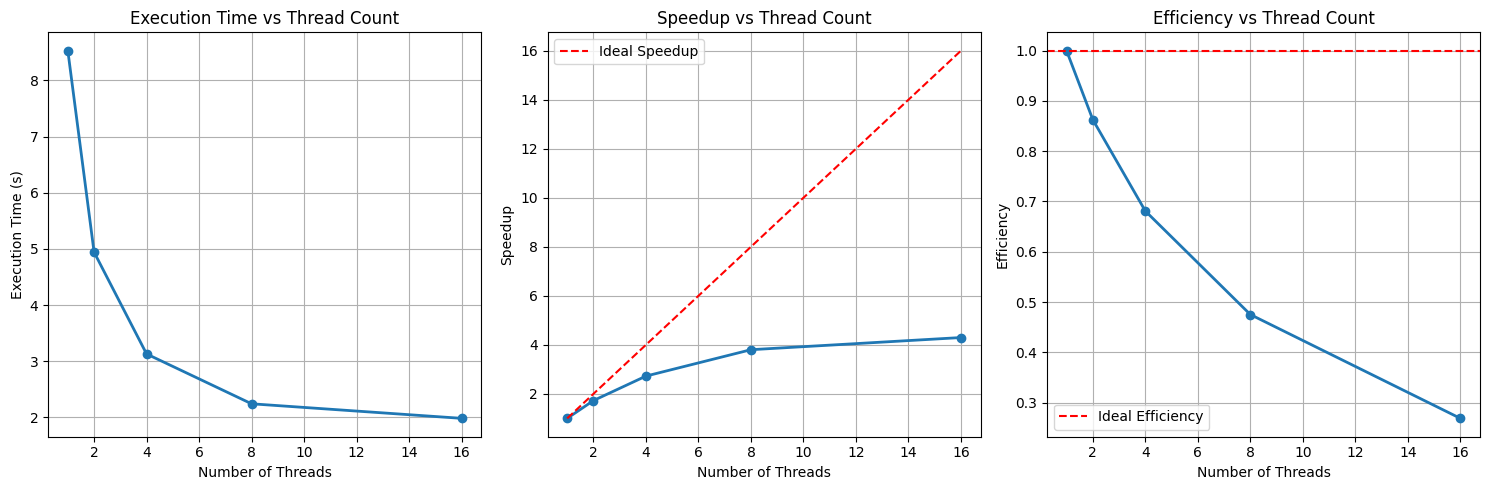

## 2. Scheduling Strategy Analysis

Schedule: Static, default chunk, Avg Time: 2.765667 seconds
Schedule: Static, chunk=16, Avg Time: 2.806000 seconds
Schedule: Dynamic, default chunk, Avg Time: 6.697333 seconds
Schedule: Dynamic, chunk=16, Avg Time: 2.169333 seconds
Schedule: Guided, default chunk, Avg Time: 1.959333 seconds
Schedule: Guided, chunk=16, Avg Time: 1.972667 seconds


,Schedule,Time,Relative Performance
0,"Static, default chunk",2.765667,0.708449
1,"Static, chunk=16",2.806000,0.698266
2,"Dynamic, default chunk",6.697333,0.292554
3,"Dynamic, chunk=16",2.169333,0.903196
4,"Guided, default chunk",1.959333,1.000000
5,"Guided, chunk=16",1.972667,0.993241


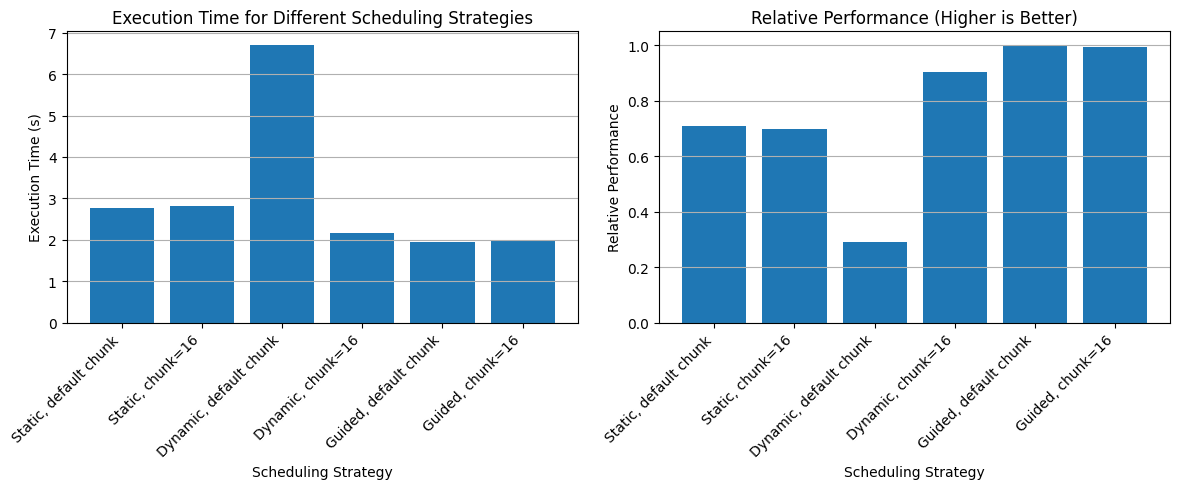

In [ ]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

c_code = """
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

int main() {
    int m = 1000;
    int n = 1000;
    double start_time, end_time;
    
    double *a = (double *)malloc(m * n * sizeof(double));
    double *b = (double *)malloc(n * m * sizeof(double));
    double *c = (double *)malloc(m * m * sizeof(double));
    
    #pragma omp parallel for collapse(2)
    for (int i = 0; i < m; i++) {
        for (int j = 0; j < n; j++) {
            a[i * n + j] = (i + 1) + (j + 1);
        }
    }
    
    #pragma omp parallel for collapse(2)
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < m; j++) {
            b[i * m + j] = (i + 1) - (j + 1);
        }
    }
    
    #pragma omp parallel for collapse(2)
    for (int i = 0; i < m; i++) {
        for (int j = 0; j < m; j++) {
            c[i * m + j] = 0;
        }
    }
    
    start_time = omp_get_wtime();
    
    #pragma omp parallel for collapse(2) schedule(runtime)
    for (int i = 0; i < m; i++) {
        for (int j = 0; j < m; j++) {
            for (int k = 0; k < n; k++) {
                c[i * m + j] += a[i * n + k] * b[k * m + j];
            }
        }
    }
    
    end_time = omp_get_wtime();
    
    printf("%f", end_time - start_time);
    free(a);
    free(b);
    free(c);
    return 0;
}
"""

with open("matmul.c", "w") as f:
    f.write(c_code)

subprocess.run(["gcc", "-fopenmp", "-o", "matmul", "matmul.c"])

display(Markdown("## 1. Thread Count Analysis"))

thread_counts = [1, 2, 4, 8, 16]
results = []

for threads in thread_counts:
    env = os.environ.copy()
    env["OMP_NUM_THREADS"] = str(threads)
    env["OMP_SCHEDULE"] = "static"
    
    output = subprocess.check_output(["matmul"], env=env)
    execution_time = float(output.decode().strip())
    results.append(execution_time)
    
    print(f"Threads: {threads}, Time: {execution_time:.6f} seconds")

df = pd.DataFrame({
    'Threads': thread_counts,
    'Time': results,
    'Speedup': [results[0]/t for t in results],
    'Efficiency': [results[0]/t/n for n, t in zip(thread_counts, results)]
})

display(df)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(df['Threads'], df['Time'], 'o-', linewidth=2)
plt.xlabel('Number of Threads')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time vs Thread Count')
plt.grid(True)
plt.subplot(1, 3, 2)
plt.plot(df['Threads'], df['Speedup'], 'o-', linewidth=2)
plt.plot(df['Threads'], df['Threads'], 'r--', label='Ideal Speedup')
plt.xlabel('Number of Threads')
plt.ylabel('Speedup')
plt.title('Speedup vs Thread Count')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(df['Threads'], df['Efficiency'], 'o-', linewidth=2)
plt.axhline(y=1, color='r', linestyle='--', label='Ideal Efficiency')
plt.xlabel('Number of Threads')
plt.ylabel('Efficiency')
plt.title('Efficiency vs Thread Count')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

display(Markdown("## 2. Scheduling Strategy Analysis"))
thread_count = 4
schedules = [
    ("static", ""), 
    ("static", "16"), 
    ("dynamic", ""), 
    ("dynamic", "16"),
    ("guided", ""),
    ("guided", "16")
]

schedule_results = []

for schedule_type, chunk_size in schedules:
    env = os.environ.copy()
    env["OMP_NUM_THREADS"] = str(thread_count)
    if chunk_size:
        env["OMP_SCHEDULE"] = f"{schedule_type},{chunk_size}"
        schedule_name = f"{schedule_type.capitalize()}, chunk={chunk_size}"
    else:
        env["OMP_SCHEDULE"] = schedule_type
        schedule_name = f"{schedule_type.capitalize()}, default chunk"
    
    times = []
    for _ in range(3):
        output = subprocess.check_output(["matmul"], env=env)
        times.append(float(output.decode().strip()))
    avg_time = sum(times) / len(times)
    schedule_results.append((schedule_name, avg_time))
    
    print(f"Schedule: {schedule_name}, Avg Time: {avg_time:.6f} seconds")
schedule_df = pd.DataFrame(schedule_results, columns=['Schedule', 'Time'])
schedule_df['Relative Performance'] = min(schedule_df['Time']) / schedule_df['Time']

display(schedule_df)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(schedule_df['Schedule'], schedule_df['Time'])
plt.xlabel('Scheduling Strategy')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time for Different Scheduling Strategies')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

plt.subplot(1, 2, 2)
plt.bar(schedule_df['Schedule'], schedule_df['Relative Performance'])
plt.xlabel('Scheduling Strategy')
plt.ylabel('Relative Performance')
plt.title('Relative Performance (Higher is Better)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()
os.remove("matmul.c")